# Analyzing a Transmon + Cavity System

Today, I'll be showing you how to compare a Transmon & Cavity simulation to experimental data using the default renderers on `Qiskit-Metal`. Our process is as follows:

1. Retrieve experimental `Lj_exp` value corresponding to the design device
2. Create design using Qiskit Metal
3. Extract eigenfrequencies & anharmonicity from `qiskit_metal.<...>.EPRanalysis` through eigenmodal simulation
4. Extract capacitance matrix from `qiskit_metal.<...>.LOManalysis`
5. Use qubit frequency, cavity frequency, anharmonicity, and capacitance matricies to calculate $g$ and $\chi$

## Step 1. Experimental $L_J$

In [1]:
import numpy as np

def find_Lj_from_qubitfreq_anharm(qubit_freq: float, qubit_anharmonicity: float) -> float:
    """
    Extract $L_J$ from the qubit frequency & anharmonicity.

    Args:
        qubit_freq: Transition frequenc from ground to first excited state. Units are linear GHz.
        Qubit_anharmonicity: Qubit anharmonicity. Units are linear GHz.

    Returns:
        LJ: Units are Nano-Henries.
    """
    import scqubits as scq
    from scqubits.core.transmon import TunableTransmon

    scq.set_units("GHz")

    Phi_0 = 2.067833848E-15
    h = 6.62607015E-34

    EJ, EC = TunableTransmon.find_EJ_EC(E01=qubit_freq, anharmonicity=qubit_anharmonicity, ncut=30)
    LJ = (Phi_0/ (2 * np.pi))**2 / (EJ * h)

    print('From scQubits')
    print(f"E_J = {EJ:0.3f} Linear GHz")
    print(f"L_J = {LJ:0.3f} nH")

    return LJ

In [2]:
exp_qubit_freq          =  3.715 # GHz
exp_qubit_anharmonicity = -0.150 # GHz # Don't forget the negative sign!

Lj_exp = find_Lj_from_qubitfreq_anharm(
    qubit_freq=exp_qubit_freq, 
    qubit_anharmonicity=exp_qubit_anharmonicity
)  # nH

From scQubits
E_J = 13.588 Linear GHz
L_J = 12.030 nH


You'll take this experimental $L_J$ and put it into your Qiskit Metal design. Specifically in...

```
design.components[<qubit name>].options.hfss_inductance = str(Lj_exp) + "nH"
design.components[<qubit name>].options.q3d_inductance  = str(Lj_exp) + "nH"
```

Remeber the inductance options want a value which looks similar to...
- `"9nH"`
- `"9 nH"`
- `"9.123nH"`
- `"9.123 nH`
- etc.


## Step 2. Create Design in Qiskit Metal

Here I outline a simple Transmon Cross coupled to readout cavity

In [3]:
qubit_name = 'qubit'
connection_pad_name = 'readout'
cavity_name = 'cavity'
feedline_name = 'clt'

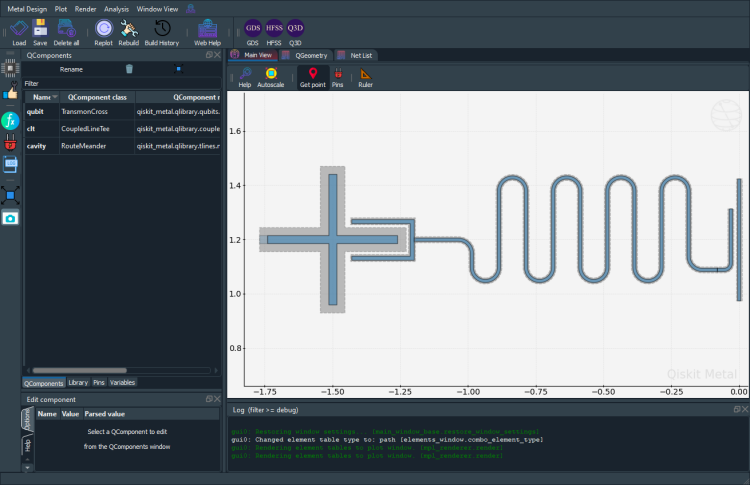

In [4]:
%load_ext autoreload
%autoreload 2
from qiskit_metal import draw, Dict, designs, MetalGUI
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal as metal
# ?metal.qlibrary.core.QComponent.add_qgeometry

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

# dir(QComponent)
cpw_width = '11.7um'

design._chips.main.size.size_x = '5mm'
design._chips.main.size.size_y = '5mm'
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee

from collections import OrderedDict

import numpy as np
xmon1_options = dict(
    connection_pads={
        connection_pad_name : dict(
            connector_location = '90', 
            connector_type = '0', 
            claw_length = '215um',
            ground_spacing = '10um', 
            claw_gap = '5.1um', 
            claw_width = '15um',
            claw_cpw_length = 0
        ),
    },
    cross_width = '30um',
    cross_length = '240um',
    cross_gap = '30um',
    orientation = '-90',
    pos_x = '-1500um',
    pos_y = '1200um',
    aedt_hfss_inductance = 10.60932E-9
)

# Create a new Transmon Cross object with name 'Q1'
q1 = TransmonCross(design, qubit_name, options=xmon1_options)

clt1_opts = Dict(prime_width = cpw_width,
                prime_gap = '5.1um',
                second_width = cpw_width,
                second_gap = '5.1um',
                coupling_space = '7.9um',
                coupling_length = '225um',
                open_termination = False,
                orientation = '-90',
                pos_y = '1200um',
                down_length = '50um')

clt1 = CoupledLineTee(design, feedline_name, clt1_opts)

cpw_total_length = 5160 + 716 + 300 + 1881.18568
cpw_total_length = str(cpw_total_length) + 'um'
cpw1_opts = Dict(pin_inputs = Dict(start_pin = Dict(component = feedline_name,
                                                    pin = 'second_end'),
                                   end_pin = Dict(component = qubit_name,
                                                  pin = connection_pad_name)),
                lead = Dict(end_straight = '70um',
                            # start_jogged_extension = jogsS),
                ),
                fillet = '49.9um',
                total_length = '3900um',#'3893.8166um', # '6776um',
                trace_width = cpw_width,
                meander = Dict(spacing = '100um',
                               asymmetry = '-150um'),
                trace_gap = '5.1um',)
cpw1 = RouteMeander(design, cavity_name, options = cpw1_opts)

gui.rebuild()
gui.zoom_on_components([qubit_name, cavity_name, feedline_name])
gui.screenshot()

# 3. Using `AnsysQiskitMetal`

In [5]:
from ansys_qiskitmetal import AnsysQiskitMetal

ansys = AnsysQiskitMetal(
    design,
    qubit_name=qubit_name,
    connection_pad_name=connection_pad_name,
    cpws_names=[cavity_name],
    feedline_name=feedline_name
)

## Simulations

### Run ANSYS -> HFSS -> Eigenmode Simulation to get the Classical Mode Frequencies.

In [ ]:
ansys.run_EigenModes(max_passes = 1)

INFO 09:26AM [connect_project]: Connecting to Ansys Desktop API...
INFO 09:26AM [load_ansys_project]: 	Opened Ansys App
INFO 09:26AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 09:26AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project15
INFO 09:26AM [connect_design]: 	Opened active design
	Design:    QubitCavity_eigenmode [Solution type: Eigenmode]
INFO 09:26AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:26AM [connect]: 	Connected to project "Project15" and design "QubitCavity_eigenmode" 😀 

INFO 09:26AM [connect_design]: 	Opened active design
	Design:    QubitCavity_eigenmode [Solution type: Eigenmode]


pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\ANSYS\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\ANSYS\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:53) [MSC v.1929 64 bit (AMD64)]


INFO:Global:Python version 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:53) [MSC v.1929 64 bit (AMD64)]


pyaedt INFO: Project Project15 set to active.


INFO:Global:Project Project15 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 09:26AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:26AM [analyze]: Analyzing setup Setup


### Run Energy Participation Ratio Analysis on Eigenmode Simulation

In [ ]:
ansys.run_EPR()
epr_results = ansys._parse_EPR()

### Run ANSYS -> Q3D Simulation to get the Capacitance Matrix

In [ ]:
ansys.run_CapMatirx(max_passes = 1)

## Parse Results

We can view all the results of the simulation by running `_parse_all_results()`

In [ ]:
ansys._parse_all_results(print_result=True)

We can also view the results by viewing the attributes of `AnsysQiskitMetal`

In [ ]:
print(ansys.qubit_freq)
print(ansys.cavity_freq)
print(ansys.anharmonicity)
print(ansys.dispersive_shift)
print(ansys.coupling_strength)